## Baseline model

Load the neccassary packackes. We will use Logistic Regression classifier as a baseline model.

In [27]:
import itertools

# Data Science
import pandas as pd
import numpy as np
import math

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

# Model evaluation functions

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def plot_roc_curve(y_score, y_test):
    """This function plots the ROC curve 
        and gives the AUC(Area under curve) value.
        
        :param y_score :predicted labels
        :param y_test  :ground truth
    """
    
    # Compute ROC curve and AUC area 
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(fpr, tpr, color='darkorange', label=r'ROC curve (AUC = %0.2f)' % (roc_auc), lw=2, alpha=0.8)

    plt.xlim([-0.05, 1.01])
    plt.ylim([-0.05, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

In [4]:
def different_thresholds(model,threshold_list,X_test, y_test):
    """This function provide us with overview of the model performances when the threshold is changed.
     
        :param model                   :the selected model(LR or RF)
        :param threshold_list          :values of threshold to predict on
        :param X_test                  :the test set
        :param y_test                  :the ground truth labels
    """
    #take the predicted probabilities for each of the classes
    pred_proba_df = pd.DataFrame(model.predict_proba(X_test))
    precisions=[] #to save the precision metric
    recalls=[]    #to save the recall metric
    f1s=[]      #to save f1 score 
    accuracies=[] #to save the accuracy
    cm=[] #to save the confusion matrix
    tp=[] #to save the true positives
    threshold_list = threshold_list
    #
    for i in threshold_list: #for each value in the threshold list make new prediction
        y_pred_new = np.where(pred_proba_df[1] > i, 1, 0)
        #calculate the precision on the new predicion
        precisions.append(precision_score(y_test, y_pred_new))
        #calculate the recall on the new predicion
        recalls.append(recall_score(y_test, y_pred_new))
        #calculate the accuracy on the new predicion
        accuracies.append(accuracy_score(y_test, y_pred_new))
        #calculate the f1 on the new predicion
        f1s.append(f1_score(y_test, y_pred_new))
        #calculate the confusion matrix on the new predicion
        cmat = confusion_matrix(y_test, y_pred_new)
        #normalize the confusion matrix
        cmat = (cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]).round(2)
        #save the true positives in a separate column
        tp.append(cmat[1,1])
        cm.append(cmat)

    new_scores=pd.DataFrame({'threshold': threshold_list, 'precision': precisions, 
                             'recall':recalls, 'accuracy':accuracies, 'f1':f1s, 'confusion_matrix':cm, 'true_positives':tp},
                            columns=['threshold', 'precision', 'recall', 'accuracy', 'f1','confusion_matrix' ,'true_positives'])
    #plot the metrics for each threshold value (new prediction)
    sns.set_style("darkgrid")
    plt.figure(1, figsize=(15, 10))
    plt.clf()
    plt.plot(new_scores['threshold'], new_scores['precision'], 'b', label='precision')
    plt.plot(new_scores['threshold'], new_scores['recall'], 'r', label='recall')
    plt.plot(new_scores['threshold'], new_scores['accuracy'], 'g', label='accuracy')
    #plt.plot(new_scores['threshold'], new_scores['true_positives'], 'y', label='tp')
    plt.ylabel('Precision Recall Accuracy', fontsize=20)
    plt.xlabel('Threshold', fontsize=20)
    plt.title('Precision Recall Accuracy over the Threshold values', fontsize=20)
    plt.legend()

## Load and transform the data
First we load and show the data in the Pandas Dataframe. Then we can start transforming the data.

In [5]:
df_train = pd.read_excel('D:/krk-datascientist-master/case2/use_case_data.xlsx')
df_train.head(5)

,REGION,MARKET,BRM,BLDIMAGE,BRANDDIFFERENTIATOR,BRANDFAMILY,BRANDONMARKET,BRANDSUBFAMILY,BRANDSUBFAMILYGROUP,BRANDSUBFAMILYGROUPING,BRANDSUBFAMILYLINE,CHARINDICATOR,BRMID,INDICATOR,RTYPE,INTERNATIONALINDICATOR,ISREPLACEMENT,ISSTRATEGIC,ITEMSHAPE,ITEMSCODE,LATESTPERIODINDEX,LEN,LENCATEGORY,PRICECLASS,LOCALCLASS,MARKETEDBRAND,MINDICATOR,NCON,NPLLAUNCHDATE,NPLLAUNCHYEAR,PCKT,PRICECLASSON,TCLASS,RETAILPACKPRICE,SPECIALFLAVOR,TRCONTE,THICATEGORY,TIPCOLOR,TRACKINGSTATUS,Market_Share
0,REGION4,MARKET70,BRM729,BLDIMAGE2,BRANDDIFFERENTIATOR278,BRANDFAMILY45,BRANDONMARKET729,BRANDSUBFAMILY86,BRANDSUBFAMILYGROUP47,BRANDSUBFAMILYGROUPING86,BRANDSUBFAMILYLINE49,CHARINDICATOR2,60099862,INDICATOR1,NaN,INTERNATIONALINDICATOR1,ISREPLACEMENT1,ISSTRATEGIC1,NaN,20,12,0.0,LENCATEGORY5,PRICECLASS4,LOCALCLASS5,MARKETEDBRAND729,MINDICATOR2,0.0,201508,NPLLAUNCHYEAR8,PCKT11,PRICECLASSON4,TCLASS2,40.0,NaN,0.0,THICATEGORY4,NaN,TRACKINGSTATUS1,-0.000419
1,REGION4,MARKET70,BRM265,BLDIMAGE2,BRANDDIFFERENTIATOR135,BRANDFAMILY21,BRANDONMARKET265,BRANDSUBFAMILY21,BRANDSUBFAMILYGROUP21,BRANDSUBFAMILYGROUPING21,BRANDSUBFAMILYLINE21,CHARINDICATOR2,60099868,INDICATOR2,NaN,INTERNATIONALINDICATOR2,ISREPLACEMENT1,ISSTRATEGIC1,NaN,20,12,0.0,LENCATEGORY2,PRICECLASS5,LOCALCLASS5,MARKETEDBRAND265,MINDICATOR1,0.0,201506,NPLLAUNCHYEAR8,PCKT11,PRICECLASSON2,TCLASS2,35.0,NaN,0.0,THICATEGORY4,NaN,TRACKINGSTATUS1,-0.000294
2,REGION4,MARKET39,BRM200,BLDIMAGE2,BRANDDIFFERENTIATOR449,BRANDFAMILY17,BRANDONMARKET200,BRANDSUBFAMILY17,BRANDSUBFAMILYGROUP17,BRANDSUBFAMILYGROUPING17,BRANDSUBFAMILYLINE17,CHARINDICATOR2,60081552,INDICATOR2,NaN,INTERNATIONALINDICATOR1,ISREPLACEMENT1,ISSTRATEGIC1,NaN,20,12,0.0,LENCATEGORY2,PRICECLASS7,LOCALCLASS5,MARKETEDBRAND200,MINDICATOR1,0.0,201409,NPLLAUNCHYEAR7,PCKT11,PRICECLASSON3,TCLASS2,19.0,NaN,0.0,THICATEGORY4,NaN,TRACKINGSTATUS2,-0.000212
3,REGION1,MARKET51,BRM631,BLDIMAGE2,BRANDDIFFERENTIATOR159,BRANDFAMILY45,BRANDONMARKET631,BRANDSUBFAMILY92,BRANDSUBFAMILYGROUP47,BRANDSUBFAMILYGROUPING92,BRANDSUBFAMILYLINE50,CHARINDICATOR1,60063035,INDICATOR1,NaN,INTERNATIONALINDICATOR1,ISREPLACEMENT1,ISSTRATEGIC1,ITEMSHAPE1,20,12,85.0,LENCATEGORY2,PRICECLASS16,LOCALCLASS5,MARKETEDBRAND631,MINDICATOR2,0.0,201309,NPLLAUNCHYEAR6,PCKT21,PRICECLASSON4,TCLASS2,460.0,SPECIALFLAVOR7,8.0,THICATEGORY4,NaN,TRACKINGSTATUS2,-0.000164
4,REGION1,MARKET51,BRM630,BLDIMAGE2,BRANDDIFFERENTIATOR158,BRANDFAMILY45,BRANDONMARKET630,BRANDSUBFAMILY87,BRANDSUBFAMILYGROUP47,BRANDSUBFAMILYGROUPING87,BRANDSUBFAMILYLINE49,CHARINDICATOR1,60063036,INDICATOR1,NaN,INTERNATIONALINDICATOR1,ISREPLACEMENT1,ISSTRATEGIC1,ITEMSHAPE1,20,12,85.0,LENCATEGORY2,PRICECLASS16,LOCALCLASS5,MARKETEDBRAND630,MINDICATOR2,0.0,201309,NPLLAUNCHYEAR6,PCKT21,PRICECLASSON4,TCLASS2,460.0,SPECIALFLAVOR7,6.0,THICATEGORY4,NaN,TRACKINGSTATUS2,-0.000160


Transform some of the features

In [6]:
#Merge REGION and MARKET into one feature
df_train['REGION_MARKET']=df_train['REGION'].astype(str)+'_'+df_train['MARKET'].astype(str)

#Encode Date into Months
df_train['LAUNCHMONTH']=df_train['NPLLAUNCHDATE'].astype(str).str[-2:]

#Add Target variable
df_train['Successful']=np.where(df_train['Market_Share']<0.007, 0, 1)

#SPECIALFLAVOR - we fill the missing values with a 'no flavor' category under the assumption that the product did not have a flavor 
df_train['SPECIALFLAVOR']=df_train['SPECIALFLAVOR'].fillna('NOFLAVOR')

#TIPCOLOR - we fill the missing values with a 'no tipcolor' category under the assumption that the product did not have a color
df_train['TIPCOLOR']=df_train['TIPCOLOR'].fillna('NOCOLOR')


## Drop the features we do not need

Some of the features we do not need, since they does not have any meaning in the model.The conclusions are based on previous exploration of the dataset.

In [7]:
# remove columns with no information and missing values (more than 50%)

# BRANDSUBFAMILYGROUPING beacuse is the same as BRANDSUBFAMILY
# BRMID is an ID
# ISREPLACEMENT has always the same value
# ITEMSHAPE is either NaN or 1
# LATESTPERIODINDEX has always the same value

# REGION and MARKET are REGION_MARKET
# RTYPE has many missing values

# NPLLAUNCHDATE is represented using only months
# NPLLAUNCHYEAR not is needed
# Market_Share is the Successful variable

df_train=df_train.drop(['BRANDSUBFAMILYGROUPING','BRMID','ISREPLACEMENT','ITEMSHAPE', 'LATESTPERIODINDEX', 'RTYPE',
                         'REGION', 'MARKET','NPLLAUNCHDATE','NPLLAUNCHYEAR','Market_Share'],axis=1)

# Show the new data frame
df_train.head(5)

,BRM,BLDIMAGE,BRANDDIFFERENTIATOR,BRANDFAMILY,BRANDONMARKET,BRANDSUBFAMILY,BRANDSUBFAMILYGROUP,BRANDSUBFAMILYLINE,CHARINDICATOR,INDICATOR,INTERNATIONALINDICATOR,ISSTRATEGIC,ITEMSCODE,LEN,LENCATEGORY,PRICECLASS,LOCALCLASS,MARKETEDBRAND,MINDICATOR,NCON,PCKT,PRICECLASSON,TCLASS,RETAILPACKPRICE,SPECIALFLAVOR,TRCONTE,THICATEGORY,TIPCOLOR,TRACKINGSTATUS,REGION_MARKET,LAUNCHMONTH,Successful
0,BRM729,BLDIMAGE2,BRANDDIFFERENTIATOR278,BRANDFAMILY45,BRANDONMARKET729,BRANDSUBFAMILY86,BRANDSUBFAMILYGROUP47,BRANDSUBFAMILYLINE49,CHARINDICATOR2,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,20,0.0,LENCATEGORY5,PRICECLASS4,LOCALCLASS5,MARKETEDBRAND729,MINDICATOR2,0.0,PCKT11,PRICECLASSON4,TCLASS2,40.0,NOFLAVOR,0.0,THICATEGORY4,NOCOLOR,TRACKINGSTATUS1,REGION4_MARKET70,08,0
1,BRM265,BLDIMAGE2,BRANDDIFFERENTIATOR135,BRANDFAMILY21,BRANDONMARKET265,BRANDSUBFAMILY21,BRANDSUBFAMILYGROUP21,BRANDSUBFAMILYLINE21,CHARINDICATOR2,INDICATOR2,INTERNATIONALINDICATOR2,ISSTRATEGIC1,20,0.0,LENCATEGORY2,PRICECLASS5,LOCALCLASS5,MARKETEDBRAND265,MINDICATOR1,0.0,PCKT11,PRICECLASSON2,TCLASS2,35.0,NOFLAVOR,0.0,THICATEGORY4,NOCOLOR,TRACKINGSTATUS1,REGION4_MARKET70,06,0
2,BRM200,BLDIMAGE2,BRANDDIFFERENTIATOR449,BRANDFAMILY17,BRANDONMARKET200,BRANDSUBFAMILY17,BRANDSUBFAMILYGROUP17,BRANDSUBFAMILYLINE17,CHARINDICATOR2,INDICATOR2,INTERNATIONALINDICATOR1,ISSTRATEGIC1,20,0.0,LENCATEGORY2,PRICECLASS7,LOCALCLASS5,MARKETEDBRAND200,MINDICATOR1,0.0,PCKT11,PRICECLASSON3,TCLASS2,19.0,NOFLAVOR,0.0,THICATEGORY4,NOCOLOR,TRACKINGSTATUS2,REGION4_MARKET39,09,0
3,BRM631,BLDIMAGE2,BRANDDIFFERENTIATOR159,BRANDFAMILY45,BRANDONMARKET631,BRANDSUBFAMILY92,BRANDSUBFAMILYGROUP47,BRANDSUBFAMILYLINE50,CHARINDICATOR1,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,20,85.0,LENCATEGORY2,PRICECLASS16,LOCALCLASS5,MARKETEDBRAND631,MINDICATOR2,0.0,PCKT21,PRICECLASSON4,TCLASS2,460.0,SPECIALFLAVOR7,8.0,THICATEGORY4,NOCOLOR,TRACKINGSTATUS2,REGION1_MARKET51,09,0
4,BRM630,BLDIMAGE2,BRANDDIFFERENTIATOR158,BRANDFAMILY45,BRANDONMARKET630,BRANDSUBFAMILY87,BRANDSUBFAMILYGROUP47,BRANDSUBFAMILYLINE49,CHARINDICATOR1,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,20,85.0,LENCATEGORY2,PRICECLASS16,LOCALCLASS5,MARKETEDBRAND630,MINDICATOR2,0.0,PCKT21,PRICECLASSON4,TCLASS2,460.0,SPECIALFLAVOR7,6.0,THICATEGORY4,NOCOLOR,TRACKINGSTATUS2,REGION1_MARKET51,09,0


## Encode the categorical features to dummy features
Before using any model all categorical features should be transformed to a dummy variables of one-hot encoding, since the category does not mean anything for the model.

In [8]:
# Transform ITEMSCODE to categorical
df_train['ITEMSCODE']=df_train['ITEMSCODE'].astype('category')

# Transform the Dataframe to a Dataframe with dummy encoding
df_train_dummies=pd.get_dummies(df_train)

# Show the new Dataframe
df_train_dummies.head(5)


,LEN,NCON,RETAILPACKPRICE,TRCONTE,Successful,BRM_BRM1,BRM_BRM10,BRM_BRM100,BRM_BRM1000,BRM_BRM1001,BRM_BRM1002,BRM_BRM1003,BRM_BRM1004,BRM_BRM1005,BRM_BRM1006,BRM_BRM1007,BRM_BRM1008,BRM_BRM1009,BRM_BRM1010,BRM_BRM1011,BRM_BRM1012,BRM_BRM1013,BRM_BRM1014,BRM_BRM1015,BRM_BRM1016,BRM_BRM1017,BRM_BRM1018,BRM_BRM1019,BRM_BRM102,BRM_BRM1020,BRM_BRM1021,BRM_BRM1022,BRM_BRM1023,BRM_BRM1024,BRM_BRM1025,BRM_BRM1026,BRM_BRM1027,BRM_BRM1028,BRM_BRM1029,BRM_BRM103,BRM_BRM1030,BRM_BRM1031,BRM_BRM1034,BRM_BRM1035,BRM_BRM1036,BRM_BRM1037,BRM_BRM1038,BRM_BRM1039,BRM_BRM104,BRM_BRM1040,...,REGION_MARKET_REGION3_MARKET38,REGION_MARKET_REGION3_MARKET42,REGION_MARKET_REGION3_MARKET43,REGION_MARKET_REGION3_MARKET47,REGION_MARKET_REGION3_MARKET49,REGION_MARKET_REGION3_MARKET58,REGION_MARKET_REGION3_MARKET60,REGION_MARKET_REGION3_MARKET61,REGION_MARKET_REGION3_MARKET64,REGION_MARKET_REGION3_MARKET66,REGION_MARKET_REGION3_MARKET76,REGION_MARKET_REGION3_MARKET8,REGION_MARKET_REGION3_MARKET80,REGION_MARKET_REGION3_MARKET87,REGION_MARKET_REGION3_MARKET88,REGION_MARKET_REGION3_MARKET9,REGION_MARKET_REGION3_MARKET91,REGION_MARKET_REGION3_MARKET97,REGION_MARKET_REGION3_MARKET98,REGION_MARKET_REGION4_MARKET114,REGION_MARKET_REGION4_MARKET115,REGION_MARKET_REGION4_MARKET12,REGION_MARKET_REGION4_MARKET14,REGION_MARKET_REGION4_MARKET16,REGION_MARKET_REGION4_MARKET19,REGION_MARKET_REGION4_MARKET20,REGION_MARKET_REGION4_MARKET22,REGION_MARKET_REGION4_MARKET27,REGION_MARKET_REGION4_MARKET28,REGION_MARKET_REGION4_MARKET30,REGION_MARKET_REGION4_MARKET39,REGION_MARKET_REGION4_MARKET40,REGION_MARKET_REGION4_MARKET5,REGION_MARKET_REGION4_MARKET70,REGION_MARKET_REGION4_MARKET78,REGION_MARKET_REGION4_MARKET83,REGION_MARKET_REGION4_MARKET84,REGION_MARKET_REGION4_MARKET85,LAUNCHMONTH_01,LAUNCHMONTH_02,LAUNCHMONTH_03,LAUNCHMONTH_04,LAUNCHMONTH_05,LAUNCHMONTH_06,LAUNCHMONTH_07,LAUNCHMONTH_08,LAUNCHMONTH_09,LAUNCHMONTH_10,LAUNCHMONTH_11,LAUNCHMONTH_12
0,0.0,0.0,40.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0,35.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.0,0.0,19.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,85.0,0.0,460.0,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,85.0,0.0,460.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Create the training and testing data

Split the features form the labels

In [9]:
y = df_train_dummies['Successful'].values
X = df_train_dummies.drop(['Successful'], axis=1)
X.head(5)

,LEN,NCON,RETAILPACKPRICE,TRCONTE,BRM_BRM1,BRM_BRM10,BRM_BRM100,BRM_BRM1000,BRM_BRM1001,BRM_BRM1002,BRM_BRM1003,BRM_BRM1004,BRM_BRM1005,BRM_BRM1006,BRM_BRM1007,BRM_BRM1008,BRM_BRM1009,BRM_BRM1010,BRM_BRM1011,BRM_BRM1012,BRM_BRM1013,BRM_BRM1014,BRM_BRM1015,BRM_BRM1016,BRM_BRM1017,BRM_BRM1018,BRM_BRM1019,BRM_BRM102,BRM_BRM1020,BRM_BRM1021,BRM_BRM1022,BRM_BRM1023,BRM_BRM1024,BRM_BRM1025,BRM_BRM1026,BRM_BRM1027,BRM_BRM1028,BRM_BRM1029,BRM_BRM103,BRM_BRM1030,BRM_BRM1031,BRM_BRM1034,BRM_BRM1035,BRM_BRM1036,BRM_BRM1037,BRM_BRM1038,BRM_BRM1039,BRM_BRM104,BRM_BRM1040,BRM_BRM1041,...,REGION_MARKET_REGION3_MARKET38,REGION_MARKET_REGION3_MARKET42,REGION_MARKET_REGION3_MARKET43,REGION_MARKET_REGION3_MARKET47,REGION_MARKET_REGION3_MARKET49,REGION_MARKET_REGION3_MARKET58,REGION_MARKET_REGION3_MARKET60,REGION_MARKET_REGION3_MARKET61,REGION_MARKET_REGION3_MARKET64,REGION_MARKET_REGION3_MARKET66,REGION_MARKET_REGION3_MARKET76,REGION_MARKET_REGION3_MARKET8,REGION_MARKET_REGION3_MARKET80,REGION_MARKET_REGION3_MARKET87,REGION_MARKET_REGION3_MARKET88,REGION_MARKET_REGION3_MARKET9,REGION_MARKET_REGION3_MARKET91,REGION_MARKET_REGION3_MARKET97,REGION_MARKET_REGION3_MARKET98,REGION_MARKET_REGION4_MARKET114,REGION_MARKET_REGION4_MARKET115,REGION_MARKET_REGION4_MARKET12,REGION_MARKET_REGION4_MARKET14,REGION_MARKET_REGION4_MARKET16,REGION_MARKET_REGION4_MARKET19,REGION_MARKET_REGION4_MARKET20,REGION_MARKET_REGION4_MARKET22,REGION_MARKET_REGION4_MARKET27,REGION_MARKET_REGION4_MARKET28,REGION_MARKET_REGION4_MARKET30,REGION_MARKET_REGION4_MARKET39,REGION_MARKET_REGION4_MARKET40,REGION_MARKET_REGION4_MARKET5,REGION_MARKET_REGION4_MARKET70,REGION_MARKET_REGION4_MARKET78,REGION_MARKET_REGION4_MARKET83,REGION_MARKET_REGION4_MARKET84,REGION_MARKET_REGION4_MARKET85,LAUNCHMONTH_01,LAUNCHMONTH_02,LAUNCHMONTH_03,LAUNCHMONTH_04,LAUNCHMONTH_05,LAUNCHMONTH_06,LAUNCHMONTH_07,LAUNCHMONTH_08,LAUNCHMONTH_09,LAUNCHMONTH_10,LAUNCHMONTH_11,LAUNCHMONTH_12
0,0.0,0.0,40.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0,35.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.0,0.0,19.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,85.0,0.0,460.0,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,85.0,0.0,460.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Normalize the continuous features

In [10]:
scaler = StandardScaler()
X['LEN'] = scaler.fit_transform(X[['LEN']].values.astype(float))
X['NCON'] = scaler.fit_transform(X[['NCON']].values.astype(float))
X['RETAILPACKPRICE'] = scaler.fit_transform(X[['RETAILPACKPRICE']].values.astype(float))
X['TRCONTE'] = scaler.fit_transform(X[['TRCONTE']].values.astype(float))

Split the data in training and testing set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, random_state=1234, test_size=.3)

## Run Logistic Regression classifier
We run the classifier for many steps, depending on the regularization parameter, in order to select the best regularization parameter.

In [12]:
C_param_range = np.linspace(start=0.1, stop=10, num=100)  # range of all C's

gsc = GridSearchCV(
    estimator=LogisticRegression(penalty='l1',solver= 'liblinear', class_weight='balanced'),
    param_grid={
        'C': C_param_range
        
        
    },
    scoring='f1',
    cv=10
)
#Keep the test set on side and use a validation set to find the best parameters
grid_result_lr = gsc.fit(X_train, y_train) 

print("Best parameter:", grid_result_lr.best_params_)
print("Best cross-validation score(f1): %s" %grid_result_lr.best_score_)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Best parameter: {'C': 1.2000000000000002}
Best cross-validation score(f1): 0.4985023557907736


Now, we can select the best C parameter. The we train a model with that C parameter and test it on the testing set.

In [13]:
#create a model using the best paramter for C
clf = LogisticRegression(**grid_result_lr.best_params_, penalty='l1',class_weight='balanced', random_state=1234, solver= 'liblinear')
y_pred = clf.fit(X_train, y_train).predict(X_test)

print("Train Accuracy ", clf.score(X_train, y_train) * 100 , '%')
print("Test Accuracy ", accuracy_score(y_test, y_pred) * 100 , '%')

Train Accuracy  89.34221482098252 %
Test Accuracy  78.44660194174757 %


A comprehensive way to represent the results of a binary classification is a confusion matrix.
Here we plot the confusion matrix

Normalized confusion matrix
[[0.83 0.17]
 [0.4  0.6 ]]
The precision is: 0.44274809160305345
The recall is: 0.6041666666666666
The f1 score is: 0.5110132158590309


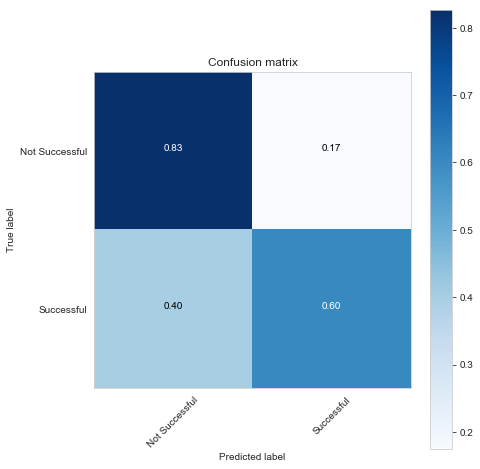

In [14]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(1, figsize=(7, 7))
plt.clf()
plot_confusion_matrix(cm, classes=['Not Successful','Successful'], title='Confusion matrix', normalize=True)

print('The precision is: {}'.format(precision_score(y_test, y_pred)))
print('The recall is: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score is: {}'.format(f1_score(y_test, y_pred)))

Coefficients learned by Logistic regression using regularization

[ 0.02 -0.11  0.05 ... -0.58  0.    0.1 ]


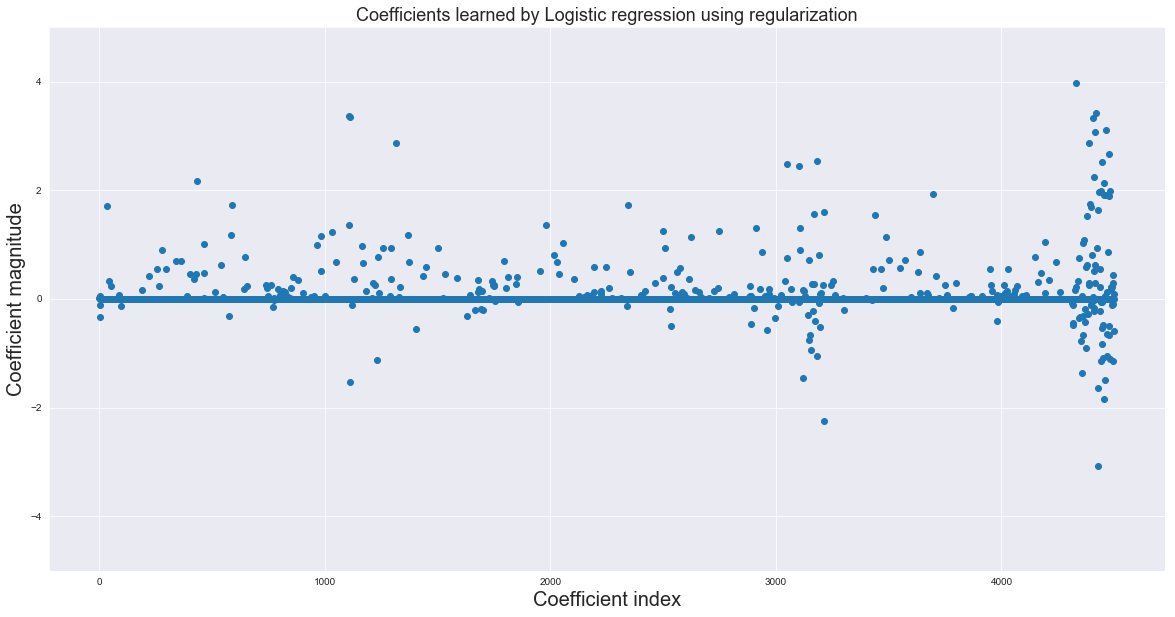

In [15]:
sns.set_style("darkgrid")
plt.figure(1, figsize=(20, 10))
plt.plot(clf.coef_.T, 'o')
plt.ylim(-5,5)
plt.xlabel("Coefficient index", fontsize=20)
plt.ylabel("Coefficient magnitude", fontsize=20)
plt.title('Coefficients learned by Logistic regression using regularization', fontsize=18)
print(clf.coef_[0])

(414, 2)


Text(0.5,1,'The top 10 and lowest 10 features according to their coefficient')

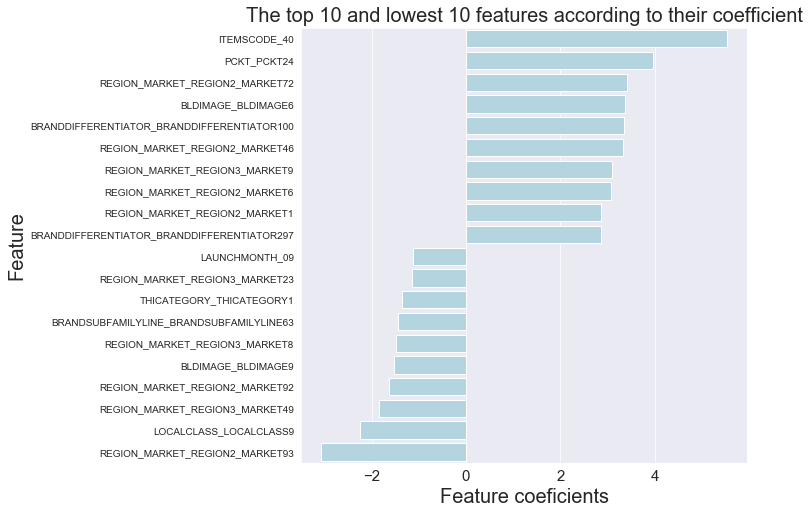

In [23]:
#We can also check the value of the coeffiecients in a tabular format 
coef = np.array(clf.coef_[0])
col = np.array(X.columns)
coef_value = pd.DataFrame({'feature': col, 'coeficient': coef}, columns=['feature', 'coeficient'])
coef_value=coef_value.sort_values('coeficient', ascending=False)

#when using L1 regularization many some features are zero aka ignored by the model
coef_not_zero = coef_value[coef_value['coeficient']!=0] #check which one are not ignored by the model
print(coef_not_zero.shape)
#take 10 with highest magnitude
highest_mag = coef_not_zero.head(10)
#take 10 with lowest mag
lowest_mag = coef_not_zero.tail(10)
#merge them into a new dataframe that will represent the features with highest and lowest magnitude
highest_lowest=pd.concat([highest_mag,lowest_mag])

plt.figure(1, figsize=(8, 8))
sns.barplot(x=highest_lowest['coeficient'],y=highest_lowest['feature'], data=highest_lowest, color='lightblue')
plt.yticks(np.arange(len(highest_lowest['feature'].unique())), highest_lowest['feature'].unique(), fontsize='10')
plt.xticks(fontsize='15') 
plt.xlabel("Feature coeficients", fontsize='20')
plt.ylabel("Feature", fontsize='20')
plt.title('The top 10 and lowest 10 features according to their coefficient', fontsize='20')

In [17]:
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

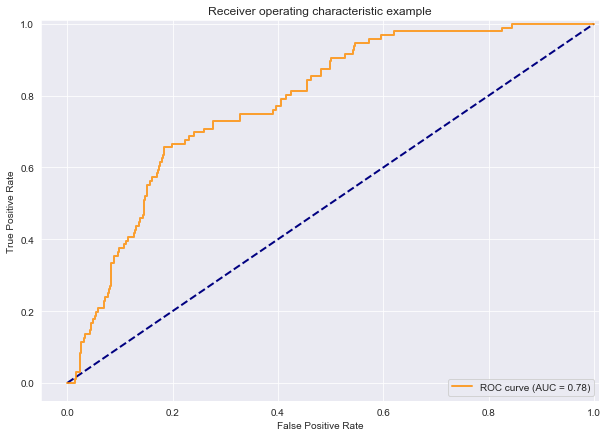

In [18]:
plot_roc_curve(y_score, y_test) #plot the curve for Logistic Regression

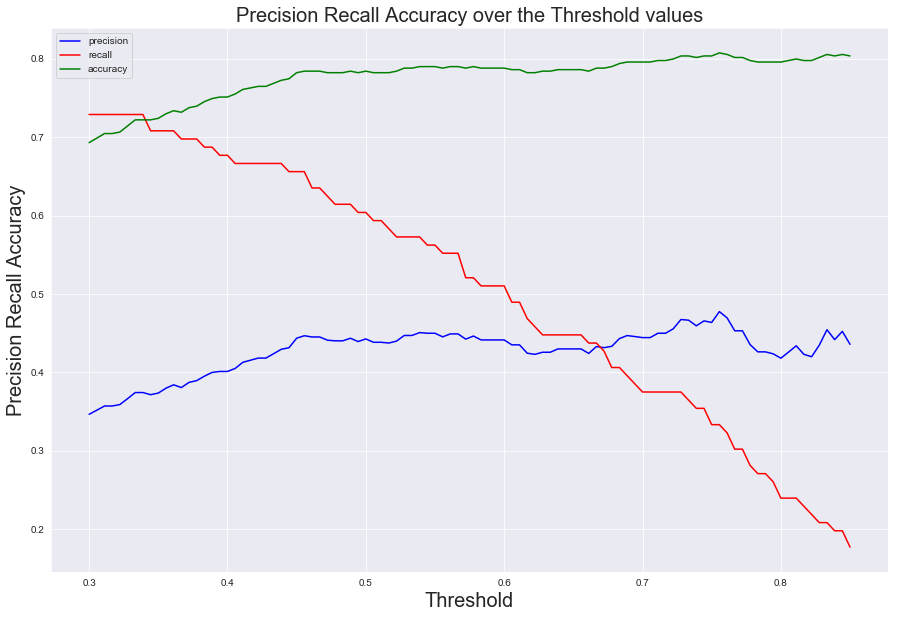

In [24]:
threshold_list = np.linspace(start=0.3, stop=0.85, num=100)
different_thresholds(clf,threshold_list, X_test, y_test)

# True Success  Probability

In [29]:
precisions = []
recalls =[]
accuracies =[]
cm =[]
threshold_model = 0.4
for i in range(100): 
    X_train, X_test, y_train, y_test = train_test_split(X.values, y, random_state=i, test_size=.3, stratify=y)
    model = LogisticRegression(**grid_result_lr.best_params_, penalty='l1',class_weight='balanced'
                            , random_state=i, solver= 'liblinear').fit(X_train, y_train)
    pred_proba_df = pd.DataFrame(model.predict_proba(X_test))
    y_pred_new =np.where(pred_proba_df[1]>threshold_model,1, 0)
    #y_pred_new = model.predict(X_test)
    current_precision = precision_score(y_test,y_pred_new)
    recalls.append(recall_score(y_test, y_pred_new))
    accuracies.append(accuracy_score(y_test, y_pred_new))
    cmat = confusion_matrix(y_test, y_pred_new)
    cmat = (cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]).round(2)
    cm.append(cmat)
    precisions.append(current_precision)

In [30]:
precisions
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
lower_ci = mean_acc-(1.96 * std_acc / math.sqrt(100))
upper_ci = mean_acc+(1.96 * std_acc / math.sqrt(100))
print(cm[5])
print("Mean accuracy: ", np.mean(accuracies))
print("Mean recall: ", np.mean(recalls))
print("Mean precision: ", np.mean(precisions))
print("Lower limit of the 95% confidence interval:", lower_ci)
print("Upper limit of the 95% confidence interval:",upper_ci)

[[0.75 0.25]
 [0.36 0.64]]
Mean accuracy:  0.7351067961165049
Mean recall:  0.6633333333333336
Mean precision:  0.3897025330389104
Lower limit of the 95% confidence interval: 0.7317227432825225
Upper limit of the 95% confidence interval: 0.7384908489504872
